In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler , LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [2]:
###----------------------
### Some basic parameters
###----------------------

inpDir = 'D:\DNN\input' # location where input data is stored
outDir = '../../output' # location to store outputs
modelDir = '../models'
subDir = 'flower_photos'
altName = 'cnn_base'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

TEST_SIZE = 0.2

ALPHA = 0.001
EPOCHS = 5 # number of cycles to run
FLIP_MODE = 'horizontal_and_vertical'
ROTATION = (-0.1,0.1)
FILL_MODE = 'nearest'
BATCH_SIZE = 8 # inline of Training Rows being 60000
IMG_HEIGHT = 200
IMG_WIDTH = 200


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'medium',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'medium',
          'axes.titlesize'  :'large',
          'xtick.labelsize' :'medium',
          'ytick.labelsize' :'medium',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [3]:
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm # type: ignore
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();


def fn_plot_label(tr_ds, ts_ds):
    
    plt.figure(figsize = (15,5)) # instantiate the figure
    
    plt.subplot(1,2,1) # first out of 2

    train_labels = tf.concat([lbl for img, lbl in tr_ds], axis = 0).numpy() # get the labels

    unique, _, counts = tf.unique_with_counts(train_labels) # get counts

    plt.bar(range(len(unique)), counts, align='center', color = 'DarkBlue') # barplot the counts

    plt.xticks(range(len(unique)), class_names)

    plt.title('Training Set')

    plt.subplot(1,2,2)
    
    test_labels = tf.concat([lbl for img, lbl in ts_ds], axis = 0).numpy()

    unique, _, counts = tf.unique_with_counts(test_labels)

    plt.bar(range(len(unique)), counts, align='center', color = 'Orange')

    plt.xticks(range(len(unique)), class_names)

    plt.title('Test Set')

In [4]:
data_dir = os.path.join(inpDir, subDir)
data_dir

'D:\\DNN\\input\\flower_photos'

In [5]:
os.listdir(data_dir)


['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [6]:
# create training data
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='training', # purpose
    seed=RANDOM_STATE, 
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)
# test data
test_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='validation', # purpose
    seed=RANDOM_STATE, 
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
# is it picking class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [8]:
class_dict = { k : v for k,v in enumerate(class_names)}
class_dict

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [9]:
num_classes = len(class_names)
num_classes

5

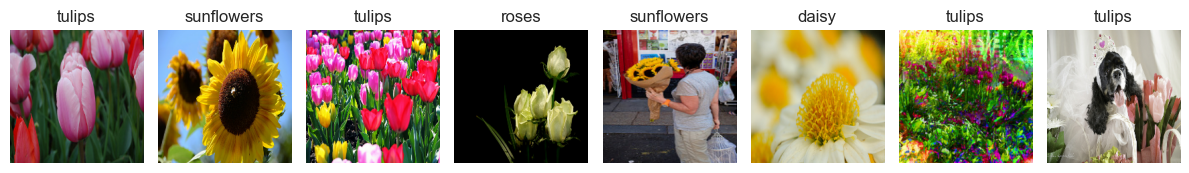

In [10]:
plt.figure(figsize=(12,6))

for images, labels in train_ds.take(1):
    for i in range (BATCH_SIZE):
        plt.subplot(int(BATCH_SIZE/8), 8, i +1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
plt.show()

In [ ]:
#

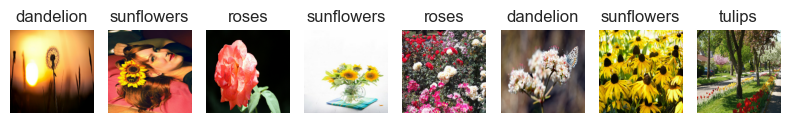

In [11]:
plt.figure(figsize=(8,4))

for images, labels in test_ds.take(1): # get me one batch
    
    for i in range (BATCH_SIZE): # loop over batch
        
        plt.subplot(int(BATCH_SIZE/8), 8, i +1) # access the axis
        
        plt.grid(False) # no to grid
        
        plt.imshow(images[i].numpy().astype('uint8')) # show image convert to numpy and int
        
        plt.title(class_names[labels[i]])
        
        plt.axis('off')
    
    plt.tight_layout()

plt.show()

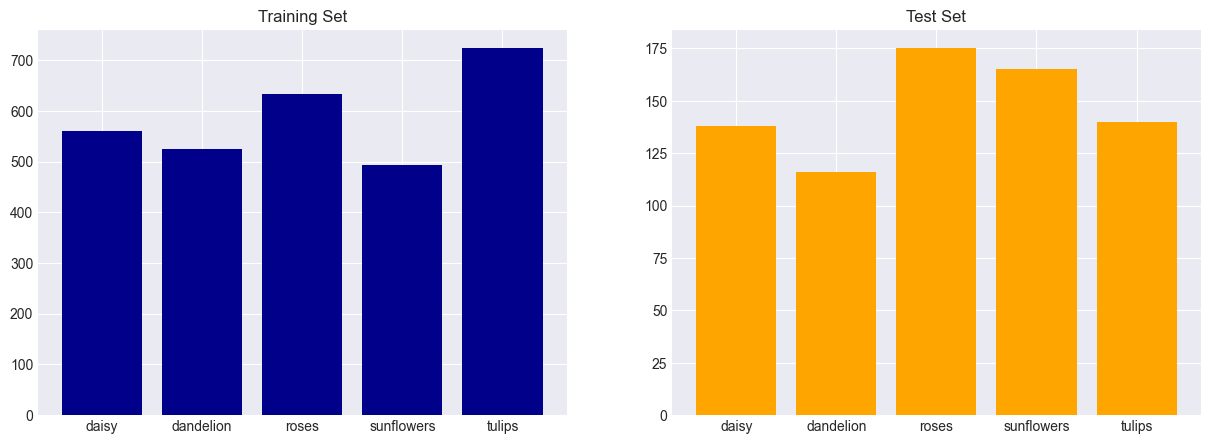

In [12]:
fn_plot_label(train_ds, test_ds)


In [13]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)


In [14]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
input_shape

(200, 200, 3)

In [15]:
densenet_model = tf.keras.applications.DenseNet169(weights = 'imagenet' , 
                                                    include_top = False,
                                                    input_shape=input_shape)

In [16]:
for layer in densenet_model.layers:
    layer.trainable = False

In [17]:
#densenet_model.summary()

In [18]:

def build_model(input_shape , n_classes):

    knl_init = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Rescaling(1./255.))
    

    model.add(densenet_model)

    ##head
    model.add(tf.keras.layers.Flatten())
 
    ##dense1
    model.add(tf.keras.layers.Dense(1664 , 
             kernel_initializer = knl_init ))
    
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Activation(activation='relu'))

    model.add(tf.keras.layers.Dropout(0.5))

    ##dense2
    model.add(tf.keras.layers.Dense(46 , 
             kernel_initializer = knl_init ))
    
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Activation(activation='relu'))

    model.add(tf.keras.layers.Dropout(0.5))

    ##dense3
    model.add(tf.keras.layers.Dense(n_classes , 
                                    kernel_initializer = knl_init))

    return model



In [19]:
model = build_model(input_shape , num_classes)
model

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
              
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              
              metrics=['accuracy'])

In [21]:
history = model.fit(train_ds, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                   # callbacks=[lr_callback, es_callback ,model_ckpt_callback ],
                    validation_data= test_ds )

Epoch 1/5


367/367 [==============================] - 363s 946ms/step - loss: 0.8128 - accuracy: 0.7119 - val_loss: 0.3529 - val_accuracy: 0.8747
Epoch 2/5
367/367 [==============================] - 330s 899ms/step - loss: 0.4199 - accuracy: 0.8699 - val_loss: 0.3234 - val_accuracy: 0.8815
Epoch 3/5
367/367 [==============================] - 327s 891ms/step - loss: 0.2779 - accuracy: 0.9159 - val_loss: 0.3326 - val_accuracy: 0.8787
Epoch 4/5
367/367 [==============================] - 325s 886ms/step - loss: 0.1931 - accuracy: 0.9479 - val_loss: 0.3387 - val_accuracy: 0.8815
Epoch 5/5
367/367 [==============================] - 326s 888ms/step - loss: 0.1425 - accuracy: 0.9591 - val_loss: 0.3046 - val_accuracy: 0.8978


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 densenet169 (Functional)    (None, 6, 6, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 59904)             0         
                                                                 
 dense (Dense)               (None, 1664)              99681920  
                                                                 
 batch_normalization (Batch  (None, 1664)              6656      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1664)              0         
                                                        

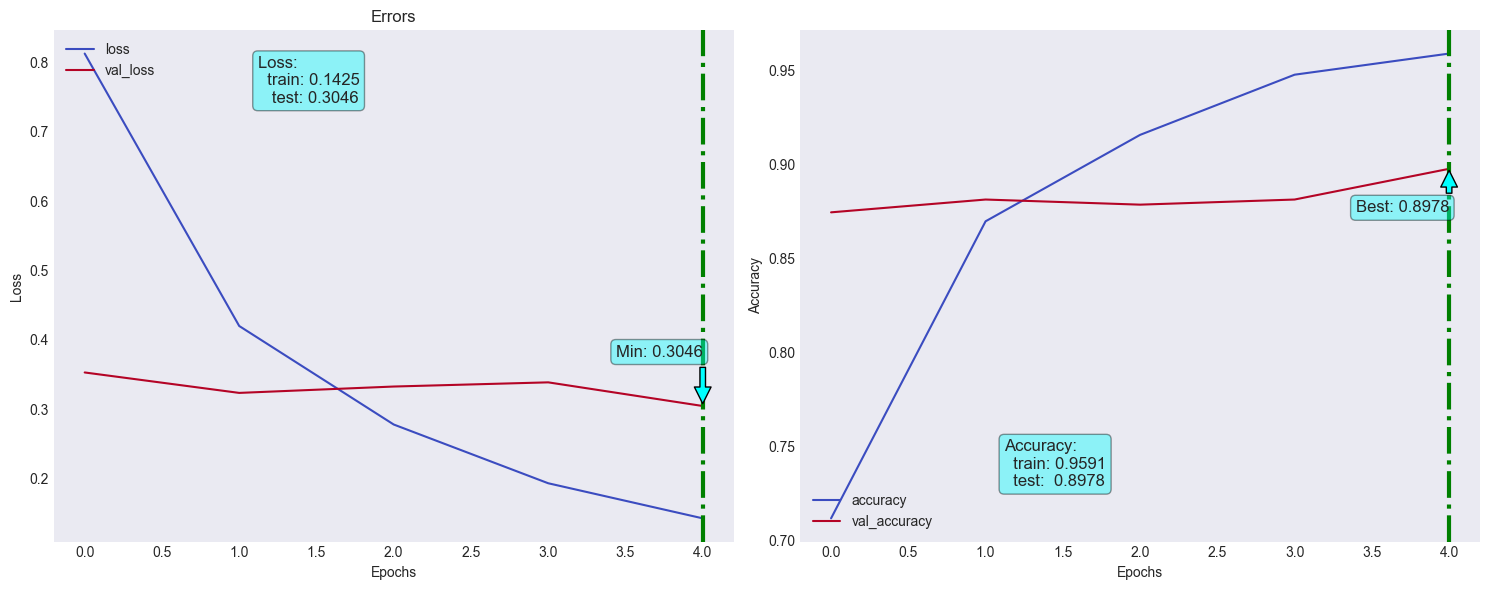

In [23]:
loss_df = pd.DataFrame(history.history)

fn_plot_tf_hist(loss_df)

In [24]:
test_loss , test_acc = model.evaluate(test_ds , verbose = 1)

92/92 [==============================] - 26s 279ms/step - loss: 0.3046 - accuracy: 0.8978


In [25]:
yhat = model.predict(test_ds)

y_test = tf.concatenate([y for x, y in test_ds], axis=0).squeeze()

y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data :', accuracy_score(y_test, y_pred))

92/92 [==============================] - 30s 280ms/step


AttributeError: module 'tensorflow' has no attribute 'concatenate'

In [ ]:
confusion_matrix(y_test, y_pred)


In [ ]:
#validation
valDir = 'valid_flowers'
val_dir = os.path.join(inpDir , valDir)

val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                     validation_split = None , 
                                                     seed = RANDOM_STATE,
                                                     image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                     batch_size = BATCH_SIZE)

In [ ]:
test_loss , test_acc = model.evaluate(val_ds , verbose = 1)

In [ ]:
yhat = model.predict(val_ds)

y_test = tf.concatenate([y for x, y in test_ds], axis=0).squeeze()

y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Valid Data :', accuracy_score(y_test, y_pred))

In [ ]:
CMAP = plt.cm.Blues

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_names.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap=CMAP, colorbar=False);

ax.set_xticklabels(class_names.values(),rotation=90, ha='right');

In [ ]:

checkpoint_filepath = os.path.join(modelDir, subDir, 'flowers_base')

model_ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = 'val_loss',
    mode = 'auto',
    verbose = 1 ,
    save_best_only = True)


es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    baseline = None,
    verbose = 1 ,
    restore_best_weights=True)


lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1)


In [ ]:
layer = tf.keras.layers.RandomRotation((-0.5,0.5) ,  fill_mode='nearest', seed=RANDOM_STATE)

plt.figure()

img_num = 0

for images, labels in train_ds.take(1):
    out_image = layer(images)
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(images[img_num].numpy().astype('uint16'))
    plt.grid(False)
    
  

In [ ]:
layer = tf.keras.layers.RandomRotation((-0.5,0.5) ,  fill_mode='nearest', seed=RANDOM_STATE)

for images, labels in train_ds.take(1):
    out_image = layer(images)
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(images[img_num].numpy().astype('uint16'))
    plt.grid(False)


    plt.subplot(1,2,2)
    plt.title("Rotated")
    plt.imshow(out_image[img_num].numpy().astype('uint16'))
    plt.grid(False)
    